In [9]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pandas_datareader
from models import MarkowitzMinVarianceModel

In [10]:
df_tpx500 = pd.read_csv("../data/tse_topix500_20001031-202010131.csv")
df_tpx500 = df_tpx500.set_index('Date')

In [19]:
st = '2000/10/31' 
ed = '2020/10/31'
symbol = '^TPX'

df = pandas_datareader.data.DataReader(symbol, 'stooq', st, ed) # daily
df = df.resample('M').mean() # daily -> monthly
df = df.sort_values(by='Date', ascending=True)
df = df.fillna(method='ffill') # 1つ前の行の値で埋める
df = df[['Close']].rename(columns={'Close': symbol})

# df = df.pct_change()
# df[:1] = 0.0 # set 0.0 to the first record

df.to_csv("../data/tse_topix_20040331-20201031.csv", index=True)
df

,^TPX
Date,
2004-03-31,1179.230000
2004-04-30,1200.991429
2004-05-31,1113.850000
2004-06-30,1158.741364
2004-07-31,1146.492381
...,...
2020-06-30,1585.746364
2020-07-31,1560.758571
2020-08-31,1595.084500


In [21]:
df_tpx = pd.read_csv("../data/tse_topix_20040331-20201031.csv")
df_tpx = df_tpx.set_index("Date")
df_tpx = df_tpx.pct_change()
df_tpx[:1] = 0.0 # set 0.0 to the first record
df_tpx

,^TPX
Date,
2004-03-31,0.000000
2004-04-30,0.018454
2004-05-31,-0.072558
2004-06-30,0.040303
2004-07-31,-0.010571
...,...
2020-06-30,0.065647
2020-07-31,-0.015758
2020-08-31,0.021993


In [12]:
# Investment period
ST_BACKTEST = datetime(2011,10,31)
ED_BACKTEST = datetime(2020,10,31)

# Risk-free rate (10Year-JGB, monthly interest)
jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond)
r_f = jgb_int * (1/12) # adjust monthly
# r_e = r_f

Portfolio Performance
Returns per month
  sharpe ratio     : 0.08571804
  mean of returns  : 0.00187582
  std of returns   : 0.02178644
    risk-free rate : 0.00000833
    capgain ratio  : 0.19569894
Returns per year
  sharpe ratio     : 0.29693599
  mean of returns  : 0.02250989
  std of returns   : 0.07547044


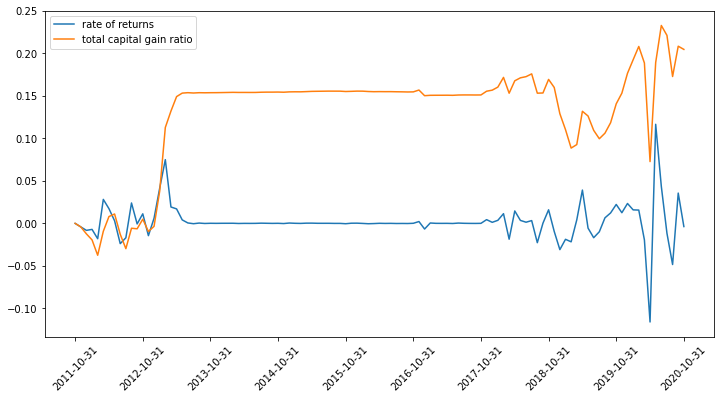

In [18]:
# Model Params
params = {
    "window_size": 36,
    "rebalance_freq": 1,
    "r_e": df_tpx,
    "r_f": r_f
}

# Data
st = (ST_BACKTEST - relativedelta(months=params["window_size"])).strftime('%Y-%m-%d')
ed = ED_BACKTEST.strftime('%Y-%m-%d')
df = df_tpx500[st:ed]

# Model (mmvp)
model = MarkowitzMinVarianceModel(df, **params)
df_bt = model.backtest()
model.evaluate_backtest(logging=True)
model.plot_returns()

In [42]:
st = '2000/10/31' 
ed = '2020/10/31'
symbol = '^TPXC30'
symbol = '^TPX'

df = pandas_datareader.data.DataReader(symbol, 'stooq', st, ed) # daily
df = df.resample('M').mean() # daily -> monthly
df = df.sort_values(by='Date', ascending=True)
df = df.fillna(method='ffill') # 1つ前の行の値で埋める
df = df[['Close']].rename(columns={'Close': symbol})
df

,^TPX
Date,
2004-03-31,1179.230000
2004-04-30,1200.991429
2004-05-31,1113.850000
2004-06-30,1158.741364
2004-07-31,1146.492381
...,...
2020-06-30,1585.746364
2020-07-31,1560.758571
2020-08-31,1595.084500


In [46]:
df_chg = df.pct_change()

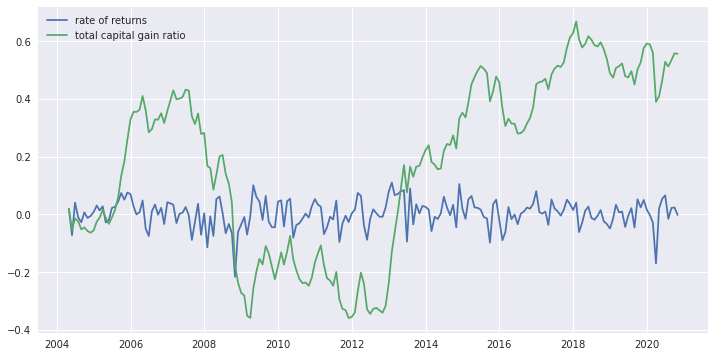

In [44]:
plt.figure(figsize=(12,6))
plt.plot(df_chg.index.values, df_chg[symbol].values, label="rate of returns")
plt.plot(df_chg.index.values, df_chg[symbol].cumsum().values, label="total capital gain ratio")
plt.legend(loc="upper left")
plt.show()

In [45]:
jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond
r_f = jgb_int * (1/12)  # adjust monthly
r_mean = df_chg[symbol].mean()
r_std = df_chg[symbol].std(ddof=True)
sharpe_ratio = (r_mean - r_f) / r_std
net_capgain = (df_chg[symbol] + 1.0).cumprod().iloc[-1] - 1.0

r_mean_peryear = 12 * r_mean
r_std_peryear = np.sqrt(12) * r_std
sharpe_ratio_peryear = (r_mean_peryear - jgb_int) / r_std_peryear

print("Portfolio Performance")
print("=======================")
print("Returns per month")
print("  sharpe ratio     : {:.8f}".format(sharpe_ratio))
print("  mean of returns  : {:.8f}".format(r_mean))
print("  std of returns   : {:.8f}".format(r_std))
print("    risk-free rate : {:.8f}".format(r_f))
print("    capgain ratio  : {:.8f}".format(net_capgain))
print("Returns per year")
print("  sharpe ratio     : {:.8f}".format(sharpe_ratio_peryear))
print("  mean of returns  : {:.8f}".format(r_mean_peryear))
print("  std of returns   : {:.8f}".format(r_std_peryear))

Portfolio Performance
Returns per month
  sharpe ratio     : 0.05830103
  mean of returns  : 0.00279017
  std of returns   : 0.04771500
    risk-free rate : 0.00000833
    capgain ratio  : 0.38143342
Returns per year
  sharpe ratio     : 0.20196071
  mean of returns  : 0.03348201
  std of returns   : 0.16528962
